In [ ]:
import numpy as np
import pandas as pd
from scipy.special import expit  # logistic function
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def generate_nonlinear_data(n_samples, p_a, p_b):
    A = np.random.binomial(1, p_a, n_samples)
    B = np.random.binomial(1, p_b, n_samples)

    Z = np.random.normal(0, 1, (n_samples, 4))

    X1 = np.sin(np.pi * A / 2) + np.cos(np.pi * B / 2) + Z[:, 0]
    X2 = A**2 - B**2 + Z[:, 1]
    X3 = np.exp(A - B) + Z[:, 2]
    X4 = np.log(1 + A**2 + B**2) + Z[:, 3]

    X = np.column_stack((X1, X2, X3, X4))

    beta = [0.1, 0.2, -0.3, 0.4, -0.5, 0.6, -0.7, 0.8]
    logits = (beta[0] + beta[1]*X1 + beta[2]*X2 + beta[3]*X3 + beta[4]*X4 +
              beta[5]*A + beta[6]*B + beta[7]*(A*B))
    p_y = expit(logits)
    Y = np.random.binomial(1, p_y)

    return pd.DataFrame({
        'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4,
        'A': A, 'B': B, 'Y': Y
    })

In [ ]:
n_samples = 100000
n_datasets = 100
p_a, p_b = 0.3, 0.9

datasets = [generate_nonlinear_data(n_samples, p_a, p_b) for _ in range(n_datasets)]

print(datasets[0].head())

         X1        X2        X3        X4  A  B  Y
0 -0.508751 -0.668886  0.561388  0.923374  0  1  0
1  0.219667 -1.528084  0.237658 -0.104261  0  1  1
2 -0.015619  0.175843  0.449420  1.670513  0  1  0
3  1.316243  0.660594  1.562783  0.038047  0  0  0
4 -1.307363 -1.080074 -0.012738 -0.686012  0  1  1


In [ ]:
def compute_stats(datasets):
    stats = []
    for var in ['X1', 'X2', 'X3', 'X4', 'A', 'B', 'Y']:
        means = [df[var].mean() for df in datasets]
        stds = [df[var].std() for df in datasets]
        stats.append({
            'Variable': var,
            'Mean': np.mean(means),
            'Std': np.mean(stds),
            'Mean CI': (np.percentile(means, 2.5), np.percentile(means, 97.5)),
            'Std CI': (np.percentile(stds, 2.5), np.percentile(stds, 97.5))
        })
    return pd.DataFrame(stats)

print("\nDescriptive Statistics:")
print(compute_stats(datasets))


Descriptive Statistics:


NameError: name 'datasets' is not defined


Correlation Matrix (first dataset):
          X1        X2        X3        X4         A         B         Y
X1  1.000000  0.232668  0.190804  0.038659  0.404842 -0.259811  0.204850
X2  0.232668  1.000000  0.197027  0.030437  0.404654 -0.264086  0.031802
X3  0.190804  0.197027  1.000000  0.019838  0.305600 -0.259501  0.259572
X4  0.038659  0.030437  0.019838  1.000000  0.196738  0.173420 -0.173589
A   0.404842  0.404654  0.305600  0.196738  1.000000 -0.001521  0.251234
B  -0.259811 -0.264086 -0.259501  0.173420 -0.001521  1.000000 -0.129429
Y   0.204850  0.031802  0.259572 -0.173589  0.251234 -0.129429  1.000000


<Figure size 1200x1000 with 0 Axes>

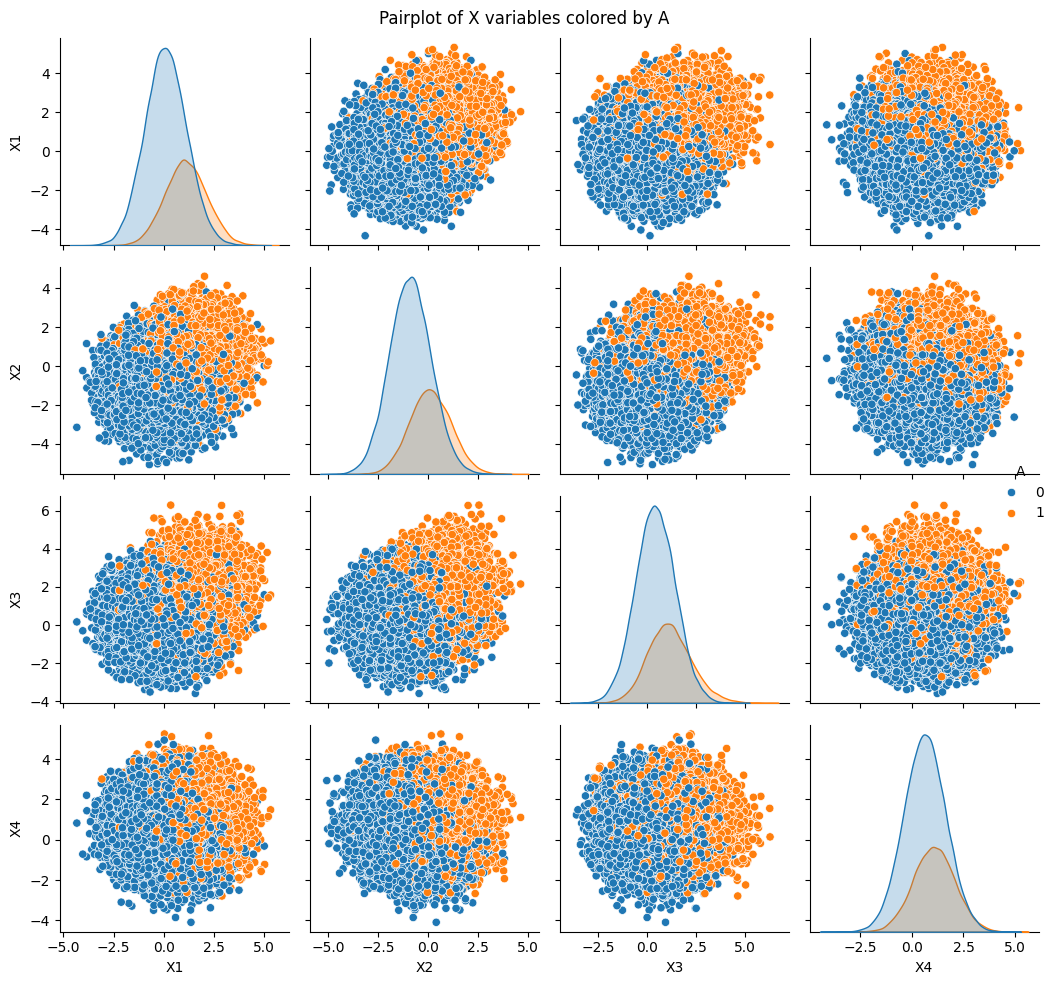

<Figure size 1200x1000 with 0 Axes>

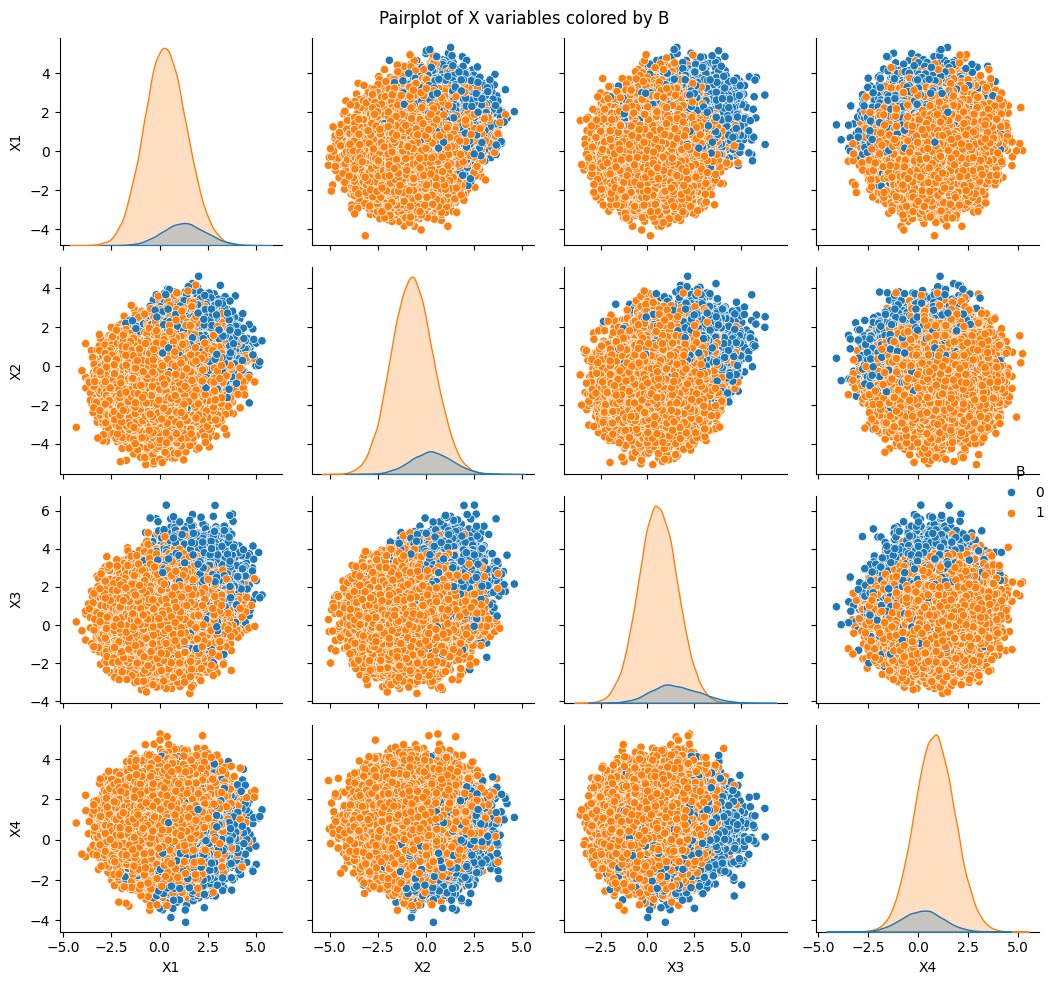

In [ ]:
def calculate_correlations(df):
    return df.corr()

print("\nCorrelation Matrix (first dataset):")
print(calculate_correlations(datasets[0]))


plt.figure(figsize=(12, 10))
sns.pairplot(datasets[0], vars=['X1', 'X2', 'X3', 'X4'], hue='A')
plt.suptitle("Pairplot of X variables colored by A")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
sns.pairplot(datasets[0], vars=['X1', 'X2', 'X3', 'X4'], hue='B')
plt.suptitle("Pairplot of X variables colored by B")
plt.tight_layout()
plt.show()

In [ ]:
def calculate_statistical_parity(datasets):
    results = []

    for i, df in enumerate(datasets):
        p_y_given_a_1 = df[(df['A'] == 1) & (df['Y'] == 1)].shape[0] / df[df['A'] == 1].shape[0]
        p_y_given_a_0 = df[(df['A'] == 0) & (df['Y'] == 1)].shape[0] / df[df['A'] == 0].shape[0]
        sp_diff_a = p_y_given_a_1 - p_y_given_a_0

        p_y_given_b_1 = df[(df['B'] == 1) & (df['Y'] == 1)].shape[0] / df[df['B'] == 1].shape[0]
        p_y_given_b_0 = df[(df['B'] == 0) & (df['Y'] == 1)].shape[0] / df[df['B'] == 0].shape[0]
        sp_diff_b = p_y_given_b_1 - p_y_given_b_0

        results.append({
            'Dataset': i+1,
            'P(Y=1|A=1)': p_y_given_a_1,
            'P(Y=1|A=0)': p_y_given_a_0,
            'SP_Diff_A': sp_diff_a,
            'P(Y=1|B=1)': p_y_given_b_1,
            'P(Y=1|B=0)': p_y_given_b_0,
            'SP_Diff_B': sp_diff_b
        })

    return pd.DataFrame(results), results

sp_results,results = calculate_statistical_parity(datasets)

print("Statistical Parity Results Summary:")
print(sp_results.describe())

Statistical Parity Results Summary:
          Dataset  P(Y=1|A=1)  P(Y=1|A=0)   SP_Diff_A  P(Y=1|B=1)  P(Y=1|B=0)  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean    50.500000    0.693920    0.416463    0.277457    0.477828    0.696958   
std     29.011492    0.002612    0.001858    0.003400    0.001401    0.004543   
min      1.000000    0.687794    0.411944    0.269339    0.474688    0.687133   
25%     25.750000    0.692154    0.415172    0.275176    0.476823    0.693447   
50%     50.500000    0.693769    0.416137    0.277095    0.477744    0.696764   
75%     75.250000    0.695867    0.417776    0.279845    0.478810    0.699838   
max    100.000000    0.701130    0.420152    0.285284    0.480982    0.706629   

        SP_Diff_B  
count  100.000000  
mean    -0.219129  
std      0.004557  
min     -0.230105  
25%     -0.221777  
50%     -0.219061  
75%     -0.215950  
max     -0.210349  


In [ ]:
results[0]

{'Dataset': 1,
 'P(Y=1|A=1)': 0.6971080669710806,
 'P(Y=1|A=0)': 0.4145575969503282,
 'SP_Diff_A': 0.28255047002075245,
 'P(Y=1|B=1)': 0.4783941703139233,
 'P(Y=1|B=0)': 0.6944277410302666,
 'SP_Diff_B': -0.21603357071634333}

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, latent_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
def compute_ind_loss(z, d):
    z_flat = z.view(z.size(0), -1)
    combined = torch.cat([z_flat, d], dim=1)
    corr_matrix = torch.corrcoef(combined.t())
    z_d_corr = corr_matrix[-1, :-1]
    ind_loss = torch.abs(z_d_corr).mean()
    return ind_loss

In [ ]:
def train_step(x, d):
    optimizer_ae.zero_grad()
    z = encoder(x)
    x_recon = decoder(z)
    recon_loss = mse_loss(x_recon, x)
    ind_loss = compute_ind_loss(z.detach(), d)
    ae_loss = recon_loss + lambda2 * ind_loss
    ae_loss.backward()
    optimizer_ae.step()

    optimizer_disc.zero_grad()
    with torch.no_grad():
        z_detached = encoder(x)
    d_pred = discriminator(z_detached.detach())
    disc_loss = mse_loss(d_pred, d)
    disc_loss.backward()
    optimizer_disc.step()

    optimizer_ae.zero_grad()
    z_adv = encoder(x)
    d_pred_adv = discriminator(z_adv)
    adv_loss = -lambda1 * mse_loss(d_pred_adv, d)
    adv_loss.backward()
    optimizer_ae.step()

    return recon_loss.item(), disc_loss.item(), ind_loss.item(), adv_loss.item()

In [ ]:
num_epochs = 10000
for epoch in range(num_epochs):
    x = torch.randn(64, input_dim)
    d = torch.randn(64, 1)

    recon_loss, disc_loss, ind_loss, adv_loss = train_step(x, d)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Recon Loss: {recon_loss:.4f}, Disc Loss: {disc_loss:.4f}, "
              f"Ind Loss: {ind_loss:.4f}, Adv Loss: {adv_loss:.4f}")

Epoch 0: Recon Loss: 0.0003, Disc Loss: 1.0373, Ind Loss: 0.1121, Adv Loss: -0.1037
Epoch 100: Recon Loss: 0.0003, Disc Loss: 0.9801, Ind Loss: 0.0834, Adv Loss: -0.0980
Epoch 200: Recon Loss: 0.0004, Disc Loss: 1.0469, Ind Loss: 0.1050, Adv Loss: -0.1047
Epoch 300: Recon Loss: 0.0002, Disc Loss: 0.7886, Ind Loss: 0.1127, Adv Loss: -0.0789
Epoch 400: Recon Loss: 0.0003, Disc Loss: 0.9796, Ind Loss: 0.1465, Adv Loss: -0.0979
Epoch 500: Recon Loss: 0.0001, Disc Loss: 1.0208, Ind Loss: 0.1239, Adv Loss: -0.1021
Epoch 600: Recon Loss: 0.0002, Disc Loss: 1.1586, Ind Loss: 0.1422, Adv Loss: -0.1159
Epoch 700: Recon Loss: 0.0001, Disc Loss: 1.0147, Ind Loss: 0.1093, Adv Loss: -0.1014
Epoch 800: Recon Loss: 0.0001, Disc Loss: 1.0427, Ind Loss: 0.1305, Adv Loss: -0.1043
Epoch 900: Recon Loss: 0.0001, Disc Loss: 0.7534, Ind Loss: 0.1073, Adv Loss: -0.0753
Epoch 1000: Recon Loss: 0.0002, Disc Loss: 1.0670, Ind Loss: 0.0851, Adv Loss: -0.1067
Epoch 1100: Recon Loss: 0.0002, Disc Loss: 1.2163, Ind 

KeyboardInterrupt: 

In [ ]:
def get_independent_representation(x):
    with torch.no_grad():
        return encoder(x)

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.network(x)

class Adversary(nn.Module):
    def __init__(self):
        super(Adversary, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

class ReconstructionNetwork(nn.Module):
    def __init__(self):
        super(ReconstructionNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
feature_extractor = FeatureExtractor().to(device)
adversary = Adversary().to(device)
reconstruction_network = ReconstructionNetwork().to(device)

adversary_loss_fn = nn.BCELoss()
reconstruction_loss_fn = nn.BCELoss()

fe_optimizer = optim.Adam(feature_extractor.parameters(), lr=0.001)
ad_optimizer = optim.Adam(adversary.parameters(), lr=0.001)
re_optimizer = optim.Adam(reconstruction_network.parameters(), lr=0.001)

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        a, b, c = row['X1'], row['X2'], row['X3']
        d, e = row['A'], row['Y']
        features = torch.tensor([a, b, c], dtype=torch.float32)
        d = torch.tensor(d, dtype=torch.float32)
        e = torch.tensor(e, dtype=torch.float32)
        return features, d, e

dataset = CustomDataset(datasets[0])
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

In [ ]:
device

device(type='cuda')

In [ ]:
num_epochs = 100
lambda_ad = 0.1

for epoch in range(num_epochs):
    for features, d, e in dataloader:
        features, d, e = features.to(device), d.to(device), e.to(device)

        fe_optimizer.zero_grad()
        ad_optimizer.zero_grad()
        re_optimizer.zero_grad()

        features_prime = feature_extractor(features)

        d_pred = adversary(features_prime).squeeze()
        loss_ad = adversary_loss_fn(d_pred, d)

        loss_ad.backward()
        ad_optimizer.step()

        fe_optimizer.zero_grad()
        re_optimizer.zero_grad()

        features_prime = feature_extractor(features)
        e_pred = reconstruction_network(features_prime).squeeze()
        loss_re = reconstruction_loss_fn(e_pred, e)

        loss_fe = loss_re - lambda_ad * loss_ad.item()  # use .item() to detach the value

        loss_fe.backward()
        fe_optimizer.step()
        re_optimizer.step()

    # if epoch % 10 == 0:
    #     print(f"Epoch {epoch}: Recon Loss: {loss_re:.4f}, Loss FE: {loss_fe:.4f}, Loss RE: {loss_re:.4f}, ")

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss FE: {loss_fe.item()}, Loss AD: {loss_ad.item()}, Loss RE: {loss_re.item()}')

print("Training complete.")

Epoch [1/100], Loss FE: 0.5546659231185913, Loss AD: 0.49332842230796814, Loss RE: 0.6039987802505493
Epoch [2/100], Loss FE: 0.6019412279129028, Loss AD: 0.42612728476524353, Loss RE: 0.6445539593696594
Epoch [3/100], Loss FE: 0.592180609703064, Loss AD: 0.5300308465957642, Loss RE: 0.6451836824417114
Epoch [4/100], Loss FE: 0.589391827583313, Loss AD: 0.4034985601902008, Loss RE: 0.6297416687011719
Epoch [5/100], Loss FE: 0.5839560627937317, Loss AD: 0.45451006293296814, Loss RE: 0.6294070482254028
Epoch [6/100], Loss FE: 0.5888009071350098, Loss AD: 0.5023173689842224, Loss RE: 0.6390326619148254
Epoch [7/100], Loss FE: 0.6153773665428162, Loss AD: 0.4668765962123871, Loss RE: 0.6620650291442871
Epoch [8/100], Loss FE: 0.5822398662567139, Loss AD: 0.47239023447036743, Loss RE: 0.6294788718223572
Epoch [9/100], Loss FE: 0.6026406288146973, Loss AD: 0.36992040276527405, Loss RE: 0.6396326422691345
Epoch [10/100], Loss FE: 0.5645416378974915, Loss AD: 0.4431391656398773, Loss RE: 0.608

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.X = torch.tensor(dataframe[['X1', 'X2', 'X3']].values, dtype=torch.float32)
        self.A = torch.tensor(dataframe['A'].values, dtype=torch.float32)
        self.Y = torch.tensor(dataframe['Y'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.A[idx], self.Y[idx]

dataset = CustomDataset(datasets[0])
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class MainNetwork(nn.Module):
    def __init__(self):
        super(MainNetwork, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.classifier = nn.Linear(32, 1)

    def forward(self, x):
        features = self.encoder(x)
        output = torch.sigmoid(self.classifier(features))
        return features, output

class AdversarialNetwork(nn.Module):
    def __init__(self):
        super(AdversarialNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        return torch.sigmoid(self.model(x))

main_net = MainNetwork().to(device)
adv_net = AdversarialNetwork().to(device)

main_optimizer = optim.Adam(main_net.parameters(), lr=0.001)
adv_optimizer = optim.Adam(adv_net.parameters(), lr=0.001)

bce_loss = nn.BCELoss()

In [ ]:
num_epochs = 100
lambda_adv = 0.1

main_net.train()
adv_net.train()
for epoch in range(num_epochs):
    for X, A, Y in dataloader:
        X, A, Y = X.to(device), A.to(device), Y.to(device)

        adv_optimizer.zero_grad()
        features, Y_pred = main_net(X)
        A_pred = adv_net(features.detach())
        adv_loss = bce_loss(A_pred, A.unsqueeze(1))
        adv_loss.backward()
        adv_optimizer.step()

        main_optimizer.zero_grad()
        features, Y_pred = main_net(X)
        A_pred = adv_net(features)

        main_loss = bce_loss(Y_pred, Y.unsqueeze(1)) - lambda_adv * bce_loss(A_pred, A.unsqueeze(1))
        main_loss.backward()
        main_optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Main Loss: {main_loss.item():.4f}, Adv Loss: {adv_loss.item():.4f}')


Epoch [10/100], Main Loss: 0.5735, Adv Loss: 0.5541
Epoch [20/100], Main Loss: 0.6000, Adv Loss: 0.6436
Epoch [30/100], Main Loss: 0.6057, Adv Loss: 0.4829
Epoch [40/100], Main Loss: 0.5787, Adv Loss: 0.4787
Epoch [50/100], Main Loss: 0.5006, Adv Loss: 0.4968
Epoch [60/100], Main Loss: 0.5728, Adv Loss: 0.5778
Epoch [70/100], Main Loss: 0.5814, Adv Loss: 0.5751
Epoch [80/100], Main Loss: 0.5633, Adv Loss: 0.5987
Epoch [90/100], Main Loss: 0.5458, Adv Loss: 0.5284
Epoch [100/100], Main Loss: 0.5958, Adv Loss: 0.5965


In [ ]:
# Calculate statistical parity for all datasets
sp_results,results = calculate_statistical_parity(datasets)

# Print summary statistics
print("Statistical Parity Results Summary:")
print(sp_results.describe())

results[0]

Statistical Parity Results Summary:
          Dataset  P(Y=1|A=1)  P(Y=1|A=0)   SP_Diff_A  P(Y=1|B=1)  P(Y=1|B=0)  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean    50.500000    0.693920    0.416463    0.277457    0.477828    0.696958   
std     29.011492    0.002612    0.001858    0.003400    0.001401    0.004543   
min      1.000000    0.687794    0.411944    0.269339    0.474688    0.687133   
25%     25.750000    0.692154    0.415172    0.275176    0.476823    0.693447   
50%     50.500000    0.693769    0.416137    0.277095    0.477744    0.696764   
75%     75.250000    0.695867    0.417776    0.279845    0.478810    0.699838   
max    100.000000    0.701130    0.420152    0.285284    0.480982    0.706629   

        SP_Diff_B  
count  100.000000  
mean    -0.219129  
std      0.004557  
min     -0.230105  
25%     -0.221777  
50%     -0.219061  
75%     -0.215950  
max     -0.210349  


{'Dataset': 1,
 'P(Y=1|A=1)': 0.6971080669710806,
 'P(Y=1|A=0)': 0.4145575969503282,
 'SP_Diff_A': 0.28255047002075245,
 'P(Y=1|B=1)': 0.4783941703139233,
 'P(Y=1|B=0)': 0.6944277410302666,
 'SP_Diff_B': -0.21603357071634333}

In [ ]:
def get_debiased_features(main_net, dataloader):
    main_net.eval()  # Set the network to evaluation mode
    debiased_features = []

    with torch.no_grad():
        for X, _, _ in dataloader:
            features, _ = main_net(X)
            debiased_features.append(features)

    return torch.cat(debiased_features, dim=0)

debiased_features = get_debiased_features(main_net, dataloader)
debiased_features.shape

torch.Size([100000, 32])

In [ ]:
def calculate_statistical_parity(main_net, dataloader):
    main_net.eval()
    y_pred_a0 = []
    y_pred_a1 = []

    with torch.no_grad():
        for X, A, _ in dataloader:
            _, Y_pred = main_net(X)
            y_pred_a0.extend(Y_pred[A == 0].numpy())
            y_pred_a1.extend(Y_pred[A == 1].numpy())

    p_y1_a0 = np.mean(np.array(y_pred_a0) > 0.5)
    p_y1_a1 = np.mean(np.array(y_pred_a1) > 0.5)

    return p_y1_a0, p_y1_a1

p_y1_a0, p_y1_a1 = calculate_statistical_parity(main_net, dataloader)
print(f"P(Y=1|A=0): {p_y1_a0:.4f}")
print(f"P(Y=1|A=1): {p_y1_a1:.4f}")

P(Y=1|A=0): 0.3889
P(Y=1|A=1): 0.7008


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def compare_a_predictability(original_features, debiased_features, A):
    lr_original = LogisticRegression().fit(original_features, A)
    lr_debiased = LogisticRegression().fit(debiased_features, A)

    acc_original = accuracy_score(A, lr_original.predict(original_features))
    acc_debiased = accuracy_score(A, lr_debiased.predict(debiased_features))

    print(f"Accuracy in predicting A from original features: {acc_original:.4f}")
    print(f"Accuracy in predicting A from debiased features: {acc_debiased:.4f}")

original_features = dataset.X.numpy()
debiased_features = get_debiased_features(main_net, dataloader).numpy()
A = dataset.A.numpy()

compare_a_predictability(original_features, debiased_features, A)

Accuracy in predicting A from original features: 0.7897
Accuracy in predicting A from debiased features: 0.6978


In [ ]:
dataset.X.shape

torch.Size([100000, 3])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.X = torch.tensor(dataframe[['X1', 'X2', 'X3']].values, dtype=torch.float32)
        self.A = torch.tensor(dataframe['A'].values, dtype=torch.float32)
        self.Y = torch.tensor(dataframe['Y'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.A[idx], self.Y[idx]

class Predictor(nn.Module):
    def __init__(self, input_size):
        super(Predictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

class Adversary(nn.Module):
    def __init__(self, hidden_size):
        super(Adversary, self).__init__()
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

class AdversarialDebiasing(nn.Module):
    def __init__(self, input_size):
        super(AdversarialDebiasing, self).__init__()
        self.predictor = Predictor(input_size)
        self.adversary = Adversary(32)  # Assumes the second layer of Predictor has 32 units

    def forward(self, x):
        pred = self.predictor(x)
        hidden = torch.relu(self.predictor.fc2(torch.relu(self.predictor.fc1(x))))
        adv = self.adversary(hidden.detach())
        return pred, adv

In [ ]:
def train(model, train_loader, val_loader, epochs=100, lr=0.001, lambda_param=0.1):
    predictor_optimizer = optim.Adam(model.predictor.parameters(), lr=lr)
    adversary_optimizer = optim.Adam(model.adversary.parameters(), lr=lr)

    bce_loss = nn.BCELoss()

    for epoch in range(epochs):
        model.train()
        total_pred_loss = 0
        total_adv_loss = 0

        for X_batch, A_batch, Y_batch in train_loader:
            X_A_batch = torch.cat([X_batch, A_batch.unsqueeze(1)], dim=1)

            pred, adv = model(X_A_batch)
            pred_loss = bce_loss(pred, Y_batch.unsqueeze(1))
            adv_loss = bce_loss(adv, A_batch.unsqueeze(1))

            total_loss = pred_loss - lambda_param * adv_loss

            predictor_optimizer.zero_grad()
            total_loss.backward()
            predictor_optimizer.step()

            _, adv = model(X_A_batch)
            adv_loss = bce_loss(adv, A_batch.unsqueeze(1))

            adversary_optimizer.zero_grad()
            adv_loss.backward()
            adversary_optimizer.step()

            total_pred_loss += pred_loss.item()
            total_adv_loss += adv_loss.item()

        avg_pred_loss = total_pred_loss / len(train_loader)
        avg_adv_loss = total_adv_loss / len(train_loader)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Avg Predictor Loss: {avg_pred_loss:.4f}, "
                  f"Avg Adversary Loss: {avg_adv_loss:.4f}")

        if epoch % 20 == 0:
            model.eval()
            val_pred_loss = 0
            val_adv_loss = 0
            with torch.no_grad():
                for X_batch, A_batch, Y_batch in val_loader:
                    X_A_batch = torch.cat([X_batch, A_batch.unsqueeze(1)], dim=1)
                    pred, adv = model(X_A_batch)
                    val_pred_loss += bce_loss(pred, Y_batch.unsqueeze(1)).item()
                    val_adv_loss += bce_loss(adv, A_batch.unsqueeze(1)).item()

            avg_val_pred_loss = val_pred_loss / len(val_loader)
            avg_val_adv_loss = val_adv_loss / len(val_loader)
            print(f"Validation - Predictor Loss: {avg_val_pred_loss:.4f}, "
                  f"Adversary Loss: {avg_val_adv_loss:.4f}")

input_size = 4  # X1, X2, X3, A
model = AdversarialDebiasing(input_size)

import pandas as pd
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(datasets[0], test_size=0.2, random_state=42)
train_dataset = CustomDataset(df_train)
val_dataset = CustomDataset(df_val)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

train(model, train_loader, val_loader)

Epoch 0, Avg Predictor Loss: 0.6317, Avg Adversary Loss: 0.1997
Validation - Predictor Loss: 0.6330, Adversary Loss: 0.0432
Epoch 10, Avg Predictor Loss: 0.6269, Avg Adversary Loss: 0.0028
Epoch 20, Avg Predictor Loss: 0.6264, Avg Adversary Loss: 0.0049
Validation - Predictor Loss: 0.6322, Adversary Loss: 0.0051
Epoch 30, Avg Predictor Loss: 0.6262, Avg Adversary Loss: 0.0265
Epoch 40, Avg Predictor Loss: 0.6262, Avg Adversary Loss: 0.0157
Validation - Predictor Loss: 0.6329, Adversary Loss: 0.0113
Epoch 50, Avg Predictor Loss: 0.6259, Avg Adversary Loss: 0.0248
Epoch 60, Avg Predictor Loss: 0.6258, Avg Adversary Loss: 0.0284
Validation - Predictor Loss: 0.6344, Adversary Loss: 0.0244
Epoch 70, Avg Predictor Loss: 0.6256, Avg Adversary Loss: 0.0199
Epoch 80, Avg Predictor Loss: 0.6256, Avg Adversary Loss: 0.0119
Validation - Predictor Loss: 0.6335, Adversary Loss: 0.0074
Epoch 90, Avg Predictor Loss: 0.6255, Avg Adversary Loss: 0.0070


In [ ]:
def check_statistical_parity(model, dataloader):
    model.eval()
    predictions = []
    sensitive_attrs = []

    with torch.no_grad():
        for X_batch, A_batch, _ in dataloader:
            X_A_batch = torch.cat([X_batch, A_batch.unsqueeze(1)], dim=1)
            pred, _ = model(X_A_batch)
            predictions.extend(pred.squeeze().tolist())
            sensitive_attrs.extend(A_batch.tolist())

    predictions = np.array(predictions)
    sensitive_attrs = np.array(sensitive_attrs)

    positive_preds = predictions >= 0.5

    group_0_rate = np.mean(positive_preds[sensitive_attrs == 0])
    group_1_rate = np.mean(positive_preds[sensitive_attrs == 1])

    parity_diff = abs(group_0_rate - group_1_rate)

    return parity_diff, group_0_rate, group_1_rate

In [ ]:
parity_diff, group_0_rate, group_1_rate = check_statistical_parity(model, val_loader)
print(f"Statistical Parity Difference: {parity_diff:.4f}")
print(f"Positive prediction rate - Group 0: {group_0_rate:.4f}, Group 1: {group_1_rate:.4f}")

Statistical Parity Difference: 0.6999
Positive prediction rate - Group 0: 0.2352, Group 1: 0.9352


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.X = torch.tensor(dataframe[['X1', 'X2', 'X3']].values, dtype=torch.float32)
        self.A = torch.tensor(dataframe['A'].values, dtype=torch.float32)
        self.Y = torch.tensor(dataframe['Y'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.A[idx], self.Y[idx]

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(h))

class AdversarialNetwork(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super(AdversarialNetwork, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(h))

In [ ]:
def train_vfae(encoder, decoder, adversary, dataloader, num_epochs=100, learning_rate=0.001, lambda_adv=1.0):
    encoder.train()
    decoder.train()
    adversary.train()

    enc_optim = optim.Adam(encoder.parameters(), lr=learning_rate)
    dec_optim = optim.Adam(decoder.parameters(), lr=learning_rate)
    adv_optim = optim.Adam(adversary.parameters(), lr=learning_rate)

    reconstruction_loss = nn.MSELoss()
    adversarial_loss = nn.BCELoss()

    for epoch in range(num_epochs):
        total_reconstruction_loss = 0
        total_adversarial_loss = 0
        total_kl_loss = 0

        for X, A, Y in dataloader:
            enc_optim.zero_grad()
            dec_optim.zero_grad()
            adv_optim.zero_grad()

            mu, logvar = encoder(X)
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mu + eps * std

            X_reconstructed = decoder(z)

            recon_loss = reconstruction_loss(X_reconstructed, X)

            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

            A_pred = adversary(z.detach())
            adv_loss = adversarial_loss(A_pred, A.unsqueeze(1))
            adv_loss.backward()
            adv_optim.step()

            A_pred = adversary(z)
            adv_loss = adversarial_loss(A_pred, A.unsqueeze(1))
            total_loss = recon_loss + kl_loss + lambda_adv * adv_loss
            total_loss.backward()
            enc_optim.step()
            dec_optim.step()

            total_reconstruction_loss += recon_loss.item()
            total_adversarial_loss += adv_loss.item()
            total_kl_loss += kl_loss.item()

        print(f'Epoch {epoch+1}, Reconstruction Loss: {total_reconstruction_loss / len(dataloader)}, Adversarial Loss: {total_adversarial_loss / len(dataloader)}, KL Loss: {total_kl_loss / len(dataloader)}')

In [ ]:
import pandas as pd

dataset = CustomDataset(datasets[0])
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

input_dim = 3
hidden_dim = 128
latent_dim = 10

encoder = Encoder(input_dim, hidden_dim, latent_dim)
decoder = Decoder(latent_dim, hidden_dim, input_dim)
adversary = AdversarialNetwork(latent_dim, hidden_dim)

train_vfae(encoder, decoder, adversary, dataloader, num_epochs=100, learning_rate=0.001, lambda_adv=1.0)

Epoch 1, Reconstruction Loss: 1.4121055308815158, Adversarial Loss: 0.6156243848831148, KL Loss: 1.2139471150420207
Epoch 2, Reconstruction Loss: 1.393116402961409, Adversarial Loss: 0.6126506840786361, KL Loss: 0.05929796942664534
Epoch 3, Reconstruction Loss: 1.3926730024845093, Adversarial Loss: 0.6122305948868432, KL Loss: 0.023871501693335337
Epoch 4, Reconstruction Loss: 1.393017066714099, Adversarial Loss: 0.6118372378827971, KL Loss: 0.010281809493708794
Epoch 5, Reconstruction Loss: 1.3926336260707788, Adversarial Loss: 0.6121642290021453, KL Loss: 0.004693532081516198
Epoch 6, Reconstruction Loss: 1.3924816026712012, Adversarial Loss: 0.6119989622431947, KL Loss: 0.002560011223149117
Epoch 7, Reconstruction Loss: 1.392593992030834, Adversarial Loss: 0.6120182063116137, KL Loss: 0.0018361599930107136
Epoch 8, Reconstruction Loss: 1.3923834917490439, Adversarial Loss: 0.6119311332245312, KL Loss: 0.0016271800869870979
Epoch 9, Reconstruction Loss: 1.3928590785816808, Adversaria

In [ ]:
import torch
import numpy as np

def calculate_statistical_parity(encoder, decoder, dataloader):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        all_X = []
        all_A = []
        all_Y = []
        all_Y_pred = []

        for X, A, Y in dataloader:
            mu, logvar = encoder(X)
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mu + eps * std
            Y_pred = decoder(z).round()

            all_X.append(X)
            all_A.append(A)
            all_Y.append(Y)
            all_Y_pred.append(Y_pred)

        all_X = torch.cat(all_X)
        all_A = torch.cat(all_A)
        all_Y = torch.cat(all_Y)
        all_Y_pred = torch.cat(all_Y_pred)

        p_y1_a1 = all_Y_pred[all_A == 1].mean().item()
        p_y1_a0 = all_Y_pred[all_A == 0].mean().item()

        print(f'P(Y=1|A=1): {p_y1_a1}')
        print(f'P(Y=1|A=0): {p_y1_a0}')
        print(f'Statistical Parity Difference: {abs(p_y1_a1 - p_y1_a0)}')

    return p_y1_a1, p_y1_a0, all_Y_pred

p_y1_a1, p_y1_a0, all_Y_pred = calculate_statistical_parity(encoder, decoder, dataloader)

P(Y=1|A=1): 0.3333333432674408
P(Y=1|A=0): 0.3333333432674408
Statistical Parity Difference: 0.0


In [ ]:
all_Y_pred

tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])